In [ ]:
!pip install pydub

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
import os
from tqdm.notebook import tqdm
from pydub import AudioSegment
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import userdata
import os
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")

In [ ]:
!kaggle datasets download -d vbookshelf/respiratory-sound-database

respiratory-sound-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip "/content/respiratory-sound-database.zip"

Archive:  /content/respiratory-sound-database.zip
replace Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_Lit

In [ ]:
patient_data=pd.read_csv('/content/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['patient_id','disease'])

In [ ]:
patient_data.head()

,patient_id,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
patient_data.shape

(126, 2)

In [ ]:
patient_data['disease'].value_counts()

disease
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: count, dtype: int64

In [ ]:
one_annotation_file = pd.read_csv('/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/107_2b3_Al_mc_AKGC417L.txt',sep='\t')

In [ ]:
one_annotation_file

,0.887,2.601,1,0
0,2.601,5.327,1,0
1,5.327,7.923,1,0
2,7.923,10.530,1,0
3,10.530,13.196,1,0
4,13.196,15.565,1,0
5,15.565,18.054,1,0
6,18.054,19.101,0,0


In [ ]:
path='/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
filenames = [s.split('.')[0] for s in os.listdir(path = path) if '.txt' in s]

In [ ]:
filenames[:10]

['180_1b4_Al_mc_AKGC417L',
 '169_1b1_Lr_sc_Meditron',
 '160_2b4_Ar_mc_AKGC417L',
 '107_3p2_Ar_mc_AKGC417L',
 '174_1p4_Tc_mc_AKGC417L',
 '163_2b2_Ll_mc_AKGC417L',
 '178_1b3_Pr_mc_AKGC417L',
 '162_2b2_Ar_mc_AKGC417L',
 '178_2b2_Pr_mc_AKGC417L',
 '181_1b1_Tc_mc_LittC2SE']

In [ ]:
count = 0
for s in filenames:
    print(s.split('_'))
    count+=1
    if count == 1:
        break

['180', '1b4', 'Al', 'mc', 'AKGC417L']


In [ ]:
patient_id = []
recording_idx = []
chest_location = []
acquisition_mode = []
recording_equipment = []

for file in filenames:
    file = file.split('_')
    patient_id.append(file[0])
    recording_idx.append(file[1])
    chest_location.append(file[2])
    acquisition_mode.append(file[3])
    recording_equipment.append(file[4])


data = {
    'patient_id' : patient_id,
    'recording_idx' : recording_idx,
    'chest_location' : chest_location,
    'acquisition_mode' : acquisition_mode,
    'recording_equipment' : recording_equipment
}

annotation_df = pd.DataFrame(data)
annotation_df.head()


,patient_id,recording_idx,chest_location,acquisition_mode,recording_equipment
0,180,1b4,Al,mc,AKGC417L
1,169,1b1,Lr,sc,Meditron
2,160,2b4,Ar,mc,AKGC417L
3,107,3p2,Ar,mc,AKGC417L
4,174,1p4,Tc,mc,AKGC417L


In [ ]:
annotation_df['chest_location'].unique()

array(['Al', 'Lr', 'Ar', 'Tc', 'Ll', 'Pr', 'Pl'], dtype=object)

In [ ]:
annotation_df.shape

(920, 5)

In [ ]:
def get_file_name(file):
    return file.split('_')

In [ ]:
file_data = []
for file in tqdm(filenames):
    data = pd.read_csv(path + '/' + file + '.txt', sep='\t', names=['start', 'end', 'crackles', 'wheezes'])
    individual_file = get_file_name(file)
    data['patient_id'] = individual_file[0]
    data['recording_idx'] = individual_file[1]
    data['chest_location'] = individual_file[2]
    data['acquisition_mode'] = individual_file[3]
    data['filename'] = file
    file_data.append(data)

  0%|          | 0/920 [00:00<?, ?it/s]

In [ ]:
files_df = pd.concat(file_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,wheezes,patient_id,recording_idx,chest_location,acquisition_mode,filename
0,0.899,4.720,1,1,180,1b4,Al,mc,180_1b4_Al_mc_AKGC417L
1,4.720,8.494,1,1,180,1b4,Al,mc,180_1b4_Al_mc_AKGC417L
2,8.494,12.018,1,1,180,1b4,Al,mc,180_1b4_Al_mc_AKGC417L
3,12.018,15.554,1,1,180,1b4,Al,mc,180_1b4_Al_mc_AKGC417L
4,15.554,19.108,1,1,180,1b4,Al,mc,180_1b4_Al_mc_AKGC417L


In [ ]:
files_df.shape

(6898, 9)

In [ ]:
patient_data.patient_id=patient_data.patient_id.astype('int32')
files_df.patient_id=files_df.patient_id.astype('int32')

In [ ]:
final_df = pd.merge(files_df,patient_data,on='patient_id')

In [ ]:
final_df.head()

,start,end,crackles,wheezes,patient_id,recording_idx,chest_location,acquisition_mode,filename,disease
0,0.899,4.720,1,1,180,1b4,Al,mc,180_1b4_Al_mc_AKGC417L,COPD
1,4.720,8.494,1,1,180,1b4,Al,mc,180_1b4_Al_mc_AKGC417L,COPD
2,8.494,12.018,1,1,180,1b4,Al,mc,180_1b4_Al_mc_AKGC417L,COPD
3,12.018,15.554,1,1,180,1b4,Al,mc,180_1b4_Al_mc_AKGC417L,COPD
4,15.554,19.108,1,1,180,1b4,Al,mc,180_1b4_Al_mc_AKGC417L,COPD


In [ ]:
final_df['crackles'].value_counts()

crackles
0    4528
1    2370
Name: count, dtype: int64

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6898 entries, 0 to 6897
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   start             6898 non-null   float64
 1   end               6898 non-null   float64
 2   crackles          6898 non-null   int64  
 3   wheezes           6898 non-null   int64  
 4   patient_id        6898 non-null   int32  
 5   recording_idx     6898 non-null   object 
 6   chest_location    6898 non-null   object 
 7   acquisition_mode  6898 non-null   object 
 8   filename          6898 non-null   object 
 9   disease           6898 non-null   object 
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 512.1+ KB


In [ ]:
audio_file = '104_1b1_Ar_sc_Litt3200.wav'
audio_path='/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/' + audio_file
print(audio_path)

/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Ar_sc_Litt3200.wav


In [ ]:
import IPython.display as ipd
ipd.display(ipd.Audio('/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav', rate=7000))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ipd.display(ipd.Audio('/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/107_2b4_Ar_mc_AKGC417L.wav', rate=7000))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
filename1 = '/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav'
filename2 = '/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/107_2b4_Ar_mc_AKGC417L.wav'

In [ ]:
y1, sr1 = librosa.load(filename1)
print(y1,sr1)
tempo1, beat_frames1 = librosa.beat.beat_track(y=y1, sr=sr1)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo1))

beat_times1 = librosa.frames_to_time(beat_frames1, sr=sr1)
print(f"Beat times for file 1: {beat_times1}")

[0.0699593  0.10248855 0.09127858 ... 0.08332463 0.07993679 0.08635148] 22050
Estimated tempo: 57.42 beats per minute
Beat times for file 1: [ 1.39319728  2.34521542  3.27401361  4.20281179  5.2244898   6.2461678
  7.2678458   8.28952381  9.31120181 10.33287982 11.35455782 12.37623583
 13.39791383 14.44281179]


In [ ]:
y2, sr2 = librosa.load(filename2)
print(y2,sr2)

tempo2, beat_frames2 = librosa.beat.beat_track(y=y2, sr=sr2)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo2))

beat_times2 = librosa.frames_to_time(beat_frames2, sr=sr2)
print(f"Beat times for file 2: {beat_times2}")

[ 0.          0.          0.         ... -0.87611204 -0.8400359
 -0.90647876] 22050
Estimated tempo: 129.20 beats per minute
Beat times for file 2: [ 0.11609977  0.58049887  1.021678    1.43963719  1.85759637  2.27555556
  2.73995465  3.2275737   3.71519274  4.17959184  4.64399093  5.13160998
  5.64244898  6.08362812  6.5015873   6.91954649  7.38394558  7.82512472
  8.28952381  8.7539229   9.24154195  9.729161   10.21678005 10.65795918
 11.14557823 11.60997732 12.09759637 12.58521542 13.04961451 13.49079365
 13.93197279 14.37315193 14.81433107 15.2555102  15.76634921 16.2307483
 16.69514739 17.18276644 17.67038549 18.15800454]


# Plotting audio file

In [ ]:
# File 1
print(type(y1), type(sr1))
print(y1.shape, sr1)

<class 'numpy.ndarray'> <class 'int'>
(441000,) 22050


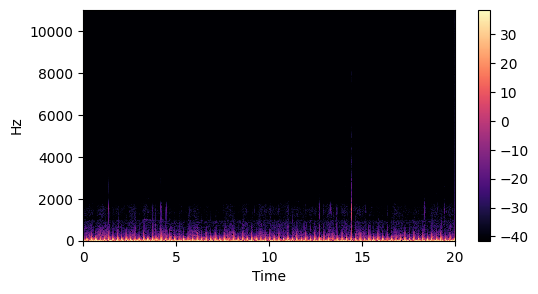

In [ ]:
Y1 = librosa.stft(y1)
Ydb1 = librosa.amplitude_to_db(abs(Y1))
plt.figure(figsize=(6, 3))
librosa.display.specshow(Ydb1, sr=sr1, x_axis='time', y_axis='hz')
plt.colorbar()

<class 'numpy.ndarray'> <class 'int'>
(441000,) 22050


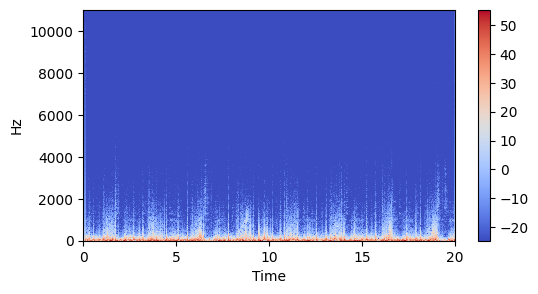

In [ ]:
# File 2
print(type(y2), type(sr2))
print(y2.shape, sr2)
Y2 = librosa.stft(y2)
Ydb2 = librosa.amplitude_to_db(abs(Y2))
plt.figure(figsize=(6, 3))
librosa.display.specshow(Ydb2, sr=sr2, x_axis='time', y_axis='hz')
plt.colorbar()

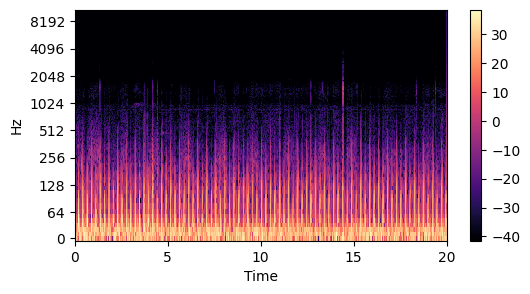

In [ ]:
plt.figure(figsize=(6, 3))
librosa.display.specshow(Ydb1, sr=sr1, x_axis='time', y_axis='log')
plt.colorbar()

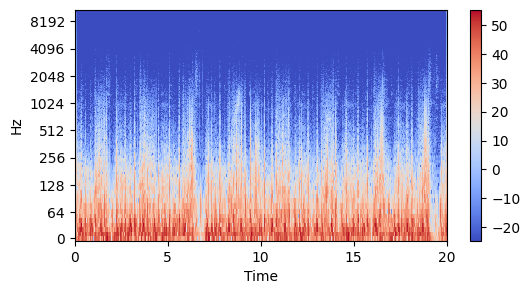

In [ ]:
plt.figure(figsize=(6, 3))
librosa.display.specshow(Ydb2, sr=sr2, x_axis='time', y_axis='log')
plt.colorbar()

(20, 862)


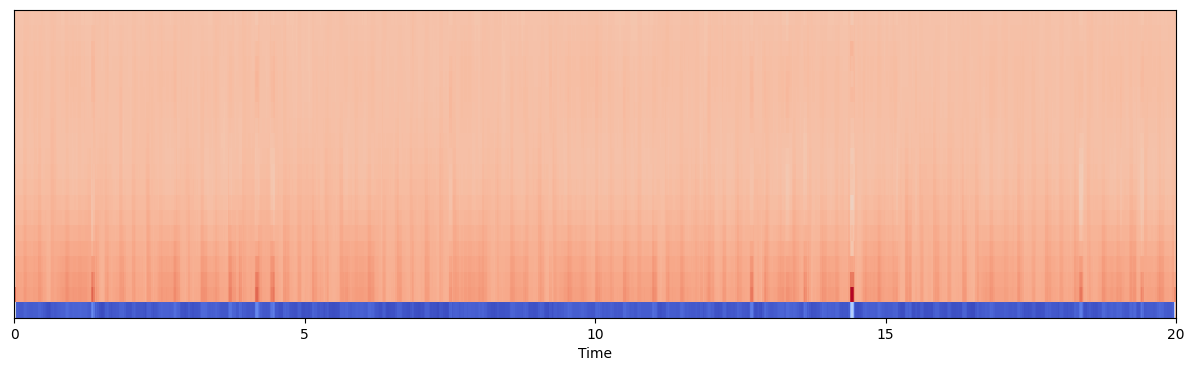

In [ ]:
fs=10
mfccs = librosa.feature.mfcc(y=y1, sr=fs)
print(mfccs.shape)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 4))
librosa.display.specshow(mfccs, sr=sr1, x_axis='time')

# Processing Audio Files

In [ ]:
def GetPureAudio(raw, start, end, sr=22050):
    '''
    It is used to extract a portion of audio data from a numpy array based on specified start and end times.

    raw=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo

    '''
    max_ind = len(raw)
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw[start_ind: end_ind]

<Axes: ylabel='None'>

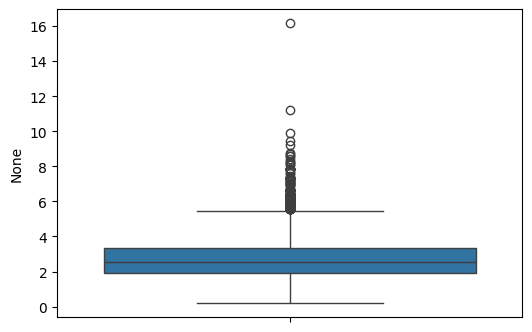

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=(final_df.end - final_df.start))

In [ ]:
# Creating directory for storing process audio files
os.makedirs('processed_audio_files')

FileExistsError: [Errno 17] File exists: 'processed_audio_files'

In [ ]:
i = 0
c = 0
for index, row in tqdm(final_df.iterrows()):
    max_length = 6
    start_time = row['start']
    end_time = row['end']
    filename = row['filename']

    # if segment duration exceeds the maximum then truncate it
    if end_time - start_time > max_length:
        end = start_time + max_length

    audio_file_location = os.path.join(path, filename + '.wav')  # Construct the full file path

    # Checking if this row is part of the same patient's audio recording
    if index > 0:
        if final_df.iloc[index-1]['filename'] == filename:
            i += 1
        else:
            i = 0
    filename = filename + '_' + str(i) + '.wav'
    save_path = 'processed_audio_files/' + filename
    c += 1

    try:
        # Loading original audio file and getting pure audio
        audio, samplerate = librosa.load(audio_file_location)
        pure_sample = GetPureAudio(audio ,start_time ,end_time,samplerate)

        # Calculating required length
        required_length = max(6 * samplerate, len(pure_sample))
        padded_data = librosa.util.pad_center(pure_sample, size=required_length)

        # Save the processed audio segment to the specified path
        sf.write(file=save_path, data=padded_data, samplerate=samplerate)
    except Exception as e:
        print(f"Error processing file {audio_file_location}: {e}")

print('Total Files Processed: ',c)



0it [00:00, ?it/s]

Total Files Processed:  6898


# Handling Imbalance Class

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

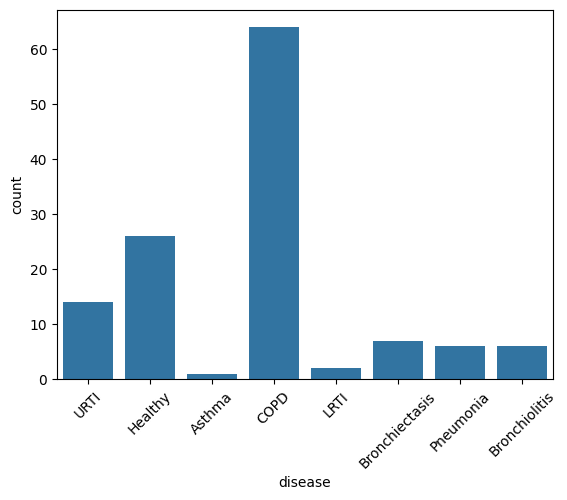

In [ ]:
sns.countplot(data=patient_data, x='disease')
plt.xticks(rotation = 45)

In [ ]:
def extract_patient_id(filename):
    return filename.split('_')[0]

In [ ]:
path = '/content/processed_audio_files'
ssss = [s.split('_')[0] for s in os.listdir(path = path)]
ssss[:1]

['159']

In [ ]:
length=len(os.listdir(path))
index=range(length)
i=0
patient_df=pd.DataFrame(index=index,columns=['patient_id','filename'])
for f in os.listdir(path):
    patient_df.iloc[i]['patient_id']=extract_patient_id(f)
    patient_df.iloc[i]['filename']=f
    i+=1

In [ ]:
patient_df.head()

,patient_id,filename
0,159,159_1b1_Ll_sc_Meditron_1.wav
1,130,130_2b2_Pl_mc_AKGC417L_6.wav
2,207,207_2b3_Pl_mc_AKGC417L_2.wav
3,203,203_1p4_Pl_mc_AKGC417L_4.wav
4,198,198_1b5_Pl_mc_AKGC417L_5.wav


In [ ]:
patient_df.patient_id=patient_df.patient_id.astype('int64')

In [ ]:
df = pd.merge(patient_df, patient_data, on='patient_id')

In [ ]:
df.head()

,patient_id,filename,disease
0,159,159_1b1_Ll_sc_Meditron_1.wav,Healthy
1,159,159_1b1_Ar_sc_Meditron_0.wav,Healthy
2,159,159_1b1_Pr_sc_Meditron_1.wav,Healthy
3,159,159_1b1_Ar_sc_Meditron_3.wav,Healthy
4,159,159_1b1_Al_sc_Meditron_7.wav,Healthy


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Healthy'),
  Text(1, 0, 'COPD'),
  Text(2, 0, 'Bronchiolitis'),
  Text(3, 0, 'URTI'),
  Text(4, 0, 'Pneumonia'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'LRTI'),
  Text(7, 0, 'Asthma')])

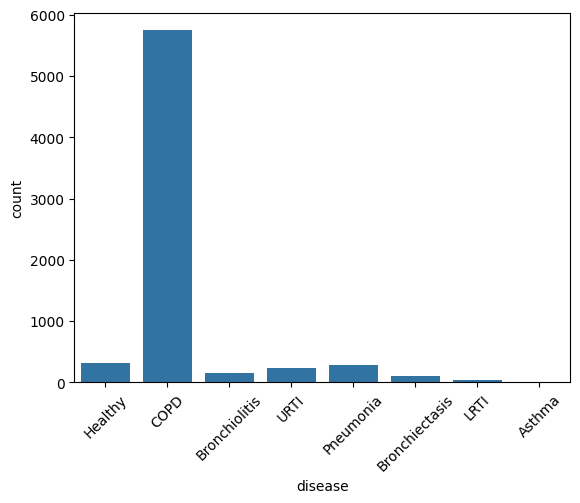

In [ ]:
sns.countplot(data=df, x='disease')
plt.xticks(rotation = 45)


# Splitting into train and test

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(df,df.disease,stratify=df.disease,random_state=42,test_size=0.25)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5173, 3)
(1725, 3)
(5173,)
(1725,)


In [ ]:
X_train.disease.value_counts()/X_train.shape[0]

disease
COPD              0.832979
Healthy           0.046588
Pneumonia         0.041369
URTI              0.035183
Bronchiolitis     0.023197
Bronchiectasis    0.015078
LRTI              0.004639
Asthma            0.000967
Name: count, dtype: float64

In [ ]:
X_train.disease.value_counts()/X_train.shape[0]

disease
COPD              0.832979
Healthy           0.046588
Pneumonia         0.041369
URTI              0.035183
Bronchiolitis     0.023197
Bronchiectasis    0.015078
LRTI              0.004639
Asthma            0.000967
Name: count, dtype: float64

In [ ]:
X_train.to_csv('train.csv')

In [ ]:
X_test.to_csv('test.csv')

# Feature Extracting and Modelling

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
train.head()

,Unnamed: 0,patient_id,filename,disease
0,1491,107,107_2b5_Pr_mc_AKGC417L_3.wav,COPD
1,5305,171,171_1b1_Al_sc_Meditron_7.wav,Healthy
2,515,130,130_2b4_Pl_mc_AKGC417L_5.wav,COPD
3,6370,153,153_1b1_Al_sc_Meditron_3.wav,Healthy
4,1283,124,124_1b1_Pr_sc_Litt3200_5.wav,COPD


In [ ]:
test.head()

,Unnamed: 0,patient_id,filename,disease
0,3163,178,178_1b2_Ar_mc_AKGC417L_5.wav,COPD
1,2918,118,118_1b1_Pl_sc_Litt3200_4.wav,COPD
2,867,203,203_1p3_Pl_mc_AKGC417L_9.wav,COPD
3,598,207,207_2b4_Ar_mc_AKGC417L_0.wav,COPD
4,4719,163,163_2b2_Al_mc_AKGC417L_0.wav,COPD


In [ ]:
# Extracting target from train and test
y_train=train.disease
y_test=test.disease

In [ ]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Feature Extraction

In [ ]:
def get_features_from_audio(path):
    soundArr,sample_rate= librosa.load(path)
    mfcc=librosa.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=librosa.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=librosa.feature.melspectrogram(y=soundArr,sr=sample_rate)
    tone = librosa.feature.tonnetz(y=soundArr,sr=sample_rate)
    specCen = librosa.feature.spectral_centroid(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec,tone, specCen

In [ ]:
root = '/content/processed_audio_files'
mfcc, cstft, mSpec = [], [], []

for idx, row in tqdm(test.iterrows()):
    filename = row['filename']
    path = os.path.join(root, filename)  # Construct the full file path
    try:
        a, b, c, d, e = get_features_from_audio(path)
        mfcc.append(a)
        cstft.append(b)
        mSpec.append(c)
    except Exception as e:
        print(f"Error processing file {path}: {e}")

print('Total Files Processed: ', len(mfcc))


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Total Files Processed:  1725


In [ ]:
shapes = [np.shape(sub_list) for sub_list in mfcc]

unique_shapes = set(shapes)

print(unique_shapes)

{(20, 304), (20, 267), (20, 276), (20, 288), (20, 303), (20, 370), (20, 309), (20, 315), (20, 260), (20, 397), (20, 278), (20, 284), (20, 348), (20, 287), (20, 357), (20, 299), (20, 317), (20, 262), (20, 259), (20, 268), (20, 274), (20, 338), (20, 286), (20, 301)}


In [ ]:
shapes1 = [np.shape(sub_list) for sub_list in cstft]

unique_shapes1 = set(shapes1)

print(unique_shapes1)

{(12, 303), (12, 370), (12, 309), (12, 315), (12, 260), (12, 397), (12, 278), (12, 284), (12, 348), (12, 287), (12, 357), (12, 299), (12, 317), (12, 262), (12, 259), (12, 268), (12, 274), (12, 338), (12, 286), (12, 301), (12, 304), (12, 267), (12, 276), (12, 288)}


In [ ]:
shapes2 = [np.shape(sub_list) for sub_list in mSpec]

unique_shapes2 = set(shapes2)

print(unique_shapes2)

{(128, 267), (128, 276), (128, 288), (128, 303), (128, 309), (128, 370), (128, 315), (128, 260), (128, 278), (128, 397), (128, 287), (128, 284), (128, 348), (128, 299), (128, 357), (128, 259), (128, 317), (128, 262), (128, 268), (128, 274), (128, 338), (128, 286), (128, 304), (128, 301)}


In [ ]:
# Determine the minimum shape among all subarrays for mfcc
min_shape = min(sub_array.shape for sub_list in mfcc for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
mfcc_padded = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in mfcc
]

# Determine the minimum shape among all subarrays for cstft
min_shape = min(sub_array.shape for sub_list in cstft for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
cstft_padded = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in cstft
]

# Determine the minimum shape among all subarrays for mSpec
min_shape = min(sub_array.shape for sub_list in mSpec for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
mSpec_padded = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in mSpec
]

In [ ]:
# Converting the padded list of lists of NumPy arrays into a NumPy array
mfcc_test = np.array(mfcc_padded)
cstft_test = np.array(cstft_padded)
mSpec_test = np.array(mSpec_padded)

print(f"mfcc: {mfcc_test.shape}")
print(f"cstft: {cstft_test.shape}")
print(f"mSpec: {mSpec_test.shape}")

mfcc: (1725, 20, 259)
cstft: (1725, 12, 259)
mSpec: (1725, 128, 259)


Similarly fetching features for training data

In [ ]:
root = '/content/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in tqdm(train.iterrows()):
    path=root + row['filename']
    a,b,c,d,e=get_features_from_audio(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)

0it [00:00, ?it/s]

In [ ]:
shapes = [np.shape(sub_list) for sub_list in mfcc]
unique_shapes = set(shapes)
print(unique_shapes)

{(20, 371), (20, 304), (20, 377), (20, 328), (20, 267), (20, 264), (20, 270), (20, 273), (20, 697), (20, 288), (20, 407), (20, 285), (20, 300), (20, 483), (20, 428), (20, 309), (20, 315), (20, 321), (20, 260), (20, 263), (20, 269), (20, 272), (20, 336), (20, 281), (20, 278), (20, 287), (20, 351), (20, 302), (20, 314), (20, 311), (20, 375), (20, 259), (20, 329), (20, 268), (20, 274), (20, 338), (20, 277), (20, 295), (20, 353), (20, 356), (20, 362)}


In [ ]:
shapes = [np.shape(sub_list) for sub_list in cstft]
unique_shapes = set(shapes)
print(unique_shapes)

{(12, 483), (12, 428), (12, 309), (12, 315), (12, 260), (12, 263), (12, 321), (12, 272), (12, 269), (12, 336), (12, 281), (12, 278), (12, 287), (12, 351), (12, 302), (12, 311), (12, 375), (12, 314), (12, 259), (12, 329), (12, 268), (12, 274), (12, 338), (12, 277), (12, 353), (12, 356), (12, 295), (12, 362), (12, 371), (12, 304), (12, 377), (12, 267), (12, 264), (12, 270), (12, 328), (12, 273), (12, 697), (12, 407), (12, 285), (12, 288), (12, 300)}


In [ ]:
shapes = [np.shape(sub_list) for sub_list in mSpec]
unique_shapes = set(shapes)
print(unique_shapes)

{(128, 377), (128, 264), (128, 328), (128, 267), (128, 273), (128, 270), (128, 697), (128, 285), (128, 288), (128, 407), (128, 300), (128, 483), (128, 309), (128, 428), (128, 315), (128, 321), (128, 260), (128, 263), (128, 269), (128, 272), (128, 278), (128, 336), (128, 281), (128, 287), (128, 351), (128, 302), (128, 311), (128, 375), (128, 314), (128, 259), (128, 329), (128, 268), (128, 274), (128, 338), (128, 277), (128, 356), (128, 295), (128, 353), (128, 304), (128, 362), (128, 371)}


In [ ]:
# Determine the minimum shape among all subarrays for mfcc
min_shape = min(sub_array.shape for sub_list in mfcc for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
mfcc_padded_train = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in mfcc
]

# Determine the minimum shape among all subarrays for cstft
min_shape = min(sub_array.shape for sub_list in cstft for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
cstft_padded_train = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in cstft
]

# Determine the minimum shape among all subarrays for mSpec
min_shape = min(sub_array.shape for sub_list in mSpec for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
mSpec_padded_train = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in mSpec
]

In [ ]:
# Converting the padded list of lists of NumPy arrays into a NumPy array
mfcc_train = np.array(mfcc_padded_train)
cstft_train = np.array(cstft_padded_train)
mSpec_train = np.array(mSpec_padded_train)

print(f"mfcc: {mfcc_train.shape}")
print(f"cstft: {cstft_train.shape}")
print(f"mSpec: {mSpec_train.shape}")

mfcc: (5173, 20, 259)
cstft: (5173, 12, 259)
mSpec: (5173, 128, 259)


# Modelling

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",  # Changed monitor to val_accuracy
        patience=5,
        verbose=1,
        mode="max",  # Changed mode to "max" since we're monitoring accuracy
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",  # Changed monitor to val_accuracy
        factor=0.1,
        patience=5,
        verbose=1,
        mode="max",  # Changed mode to "max" since we're monitoring accuracy
        min_lr=0.00001,
    )
]

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [ ]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 20, 87, 32)        832       
                                                                 
 batch_normalization_12 (Ba  (None, 20, 87, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 10, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 10, 22, 64)        18

In [ ]:
cstft_input=keras.layers.Input(shape=(12,259,1),name="cstftInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(cstft_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
cstft_output=keras.layers.GlobalMaxPooling2D()(x)

cstft_model=keras.Model(cstft_input, cstft_output, name="cstftModel")

In [ ]:
cstft_model.summary()

Model: "cstftModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cstftInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_16 (Ba  (None, 12, 87, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 6, 43, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 6, 22, 64)         1

In [ ]:
mspec_input=keras.layers.Input(shape=(128,259,1),name="mspecInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mspec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mspec_output=keras.layers.GlobalMaxPooling2D()(x)

mspec_model=keras.Model(mspec_input, mspec_output, name="mspecModel")

In [ ]:
mspec_model.summary()

Model: "mspecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mspecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 128, 87, 32)       832       
                                                                 
 batch_normalization_20 (Ba  (None, 128, 87, 32)       128       
 tchNormalization)                                               
                                                                 
 activation_20 (Activation)  (None, 128, 87, 32)       0         
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 64, 43, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 22, 64)        1

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_cstft=keras.layers.Input(shape=(12,259,1),name="cstft")
cstft=cstft_model(input_cstft)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mspec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,cstft,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_cstft,input_mSpec], output, name="Net")

In [ ]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mfcc (InputLayer)           [(None, 20, 259, 1)]         0         []                            
                                                                                                  
 cstft (InputLayer)          [(None, 12, 259, 1)]         0         []                            
                                                                                                  
 mspec (InputLayer)          [(None, 128, 259, 1)]        0         []                            
                                                                                                  
 mfccModel (Functional)      (None, 128)                  94560     ['mfcc[0][0]']                
                                                                                                

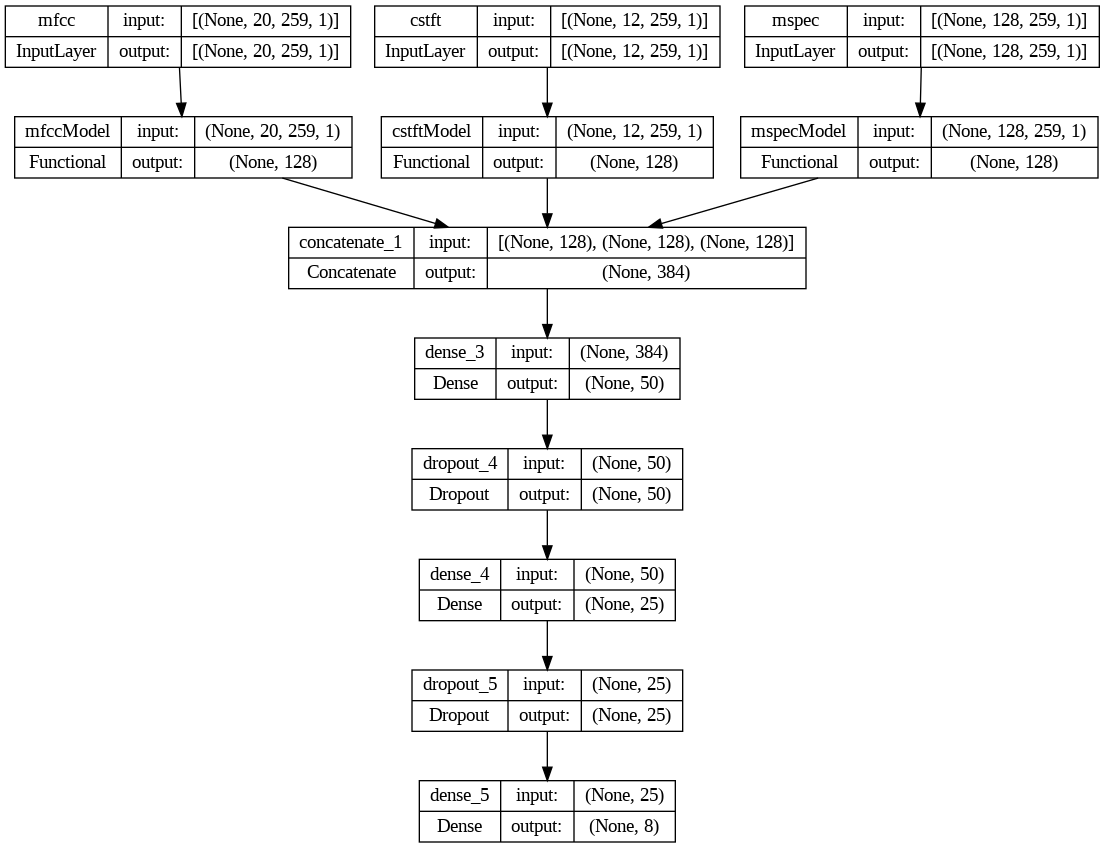

In [ ]:
keras.utils.plot_model(net, "net.png", show_shapes=True)

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
history=net.fit(
    {"mfcc":mfcc_train,"cstft":cstft_train,"mspec":mSpec_train},
    y_train,
    validation_data=({"mfcc":mfcc_test,"cstft":cstft_test,"mspec":mSpec_test},y_test),
    epochs=53,verbose=1,
    callbacks=my_callbacks
)

Epoch 1/53
162/162 [==============================] - 21s 47ms/step - loss: 0.7475 - accuracy: 0.7939 - val_loss: 0.6511 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 2/53
162/162 [==============================] - 5s 31ms/step - loss: 0.5000 - accuracy: 0.8368 - val_loss: 0.5600 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 3/53
162/162 [==============================] - 5s 32ms/step - loss: 0.4457 - accuracy: 0.8405 - val_loss: 0.3892 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 4/53
162/162 [==============================] - 6s 38ms/step - loss: 0.4109 - accuracy: 0.8486 - val_loss: 0.5110 - val_accuracy: 0.8383 - lr: 0.0010
Epoch 5/53
162/162 [==============================] - 5s 31ms/step - loss: 0.3973 - accuracy: 0.8539 - val_loss: 0.3403 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 6/53
162/162 [==============================] - 5s 33ms/step - loss: 0.3469 - accuracy: 0.8703 - val_loss: 0.4444 - val_accuracy: 0.8412 - lr: 0.0010
Epoch 7/53
162/162 [==============================] - 6s 38ms/s

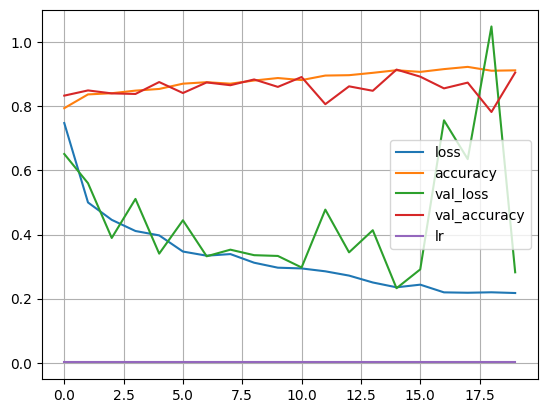

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()